In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-detection-and-test/test_set/test_set/245_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/211_2HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/247_2HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/137_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/72_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/213_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/253_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/221_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/78_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/46_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/120_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/123_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/33_HC.png
/kaggle/input/fetal-detection-and-test/test_set/test_set/105_3HC.png
/kaggle/input/fetal-detection-and-test/test_set/t

In [2]:
path2data = "../input/fetal-detection-and-test/training_set/training_set"

img_list = [i for i in os.listdir(path2data) if i.find("Annotation") is -1 and i.endswith(".png")]
ann_list = [i for i in os.listdir(path2data) if i.find("Annotation") is not -1]

print(f"# Img list: {len(img_list)}")

print(f"# Annotation list: {len(ann_list)}")

# Img list: 999
# Annotation list: 999


In [3]:
np.random.seed(2019)
rnd_list = np.random.choice(img_list, 3)
rnd_list

array(['584_HC.png', '169_HC.png', '741_HC.png'], dtype='<U11')

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

In [5]:
def show_img_mask(img,mask):
    img_mask=mark_boundaries(np.array(img), np.array(mask, dtype = np.bool), outline_color=(0,1,0), color=(0,1,0))
    plt.imshow(img_mask)

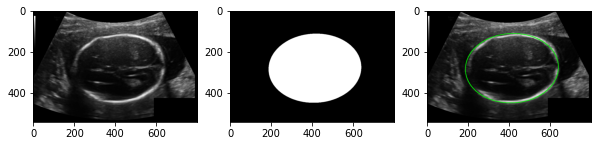

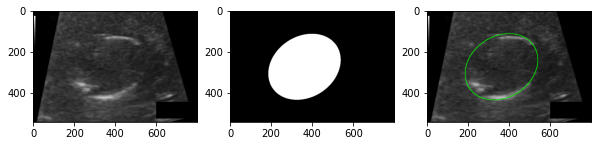

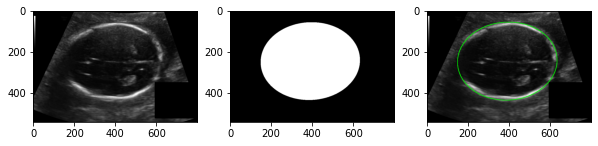

In [6]:
for i in rnd_list:
    path2img = os.path.join(path2data,i)
    path2ann = path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2ann)
    mask = ndi.binary_fill_holes(annt_edges)
    
    plt.figure(figsize= (10,10))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray")
    
    
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    
    
    plt.subplot(1,3,3)
    mask = mask*1
    show_img_mask(img,mask)
    

In [7]:
# !conda install -c conda-forge imgaug --yes
# !conda install -c albumentations -c albumentations --yes

In [8]:
from albumentations import (
HorizontalFlip,
VerticalFlip,
Compose,
Resize
)

In [9]:
h,w = 128,192
transform_train = Compose([
    Resize(h,w),
    HorizontalFlip(p = 0.5),
    VerticalFlip(p = 0.5)
])

transform_val = Resize(h,w)


In [10]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

In [11]:
class fetal_dataset(Dataset):
    def __init__(self, path2data, transform= None):
        img_list = [i for i in os.listdir(path2data) if i.find("Annotation") is -1 and i.endswith(".png")]
        ann_list = [i for i in os.listdir(path2data) if i.find("Annotation") is not -1]
        
        self.path2imgs = [os.path.join(path2data, fn) for fn in img_list]
        
        self.path2annts = [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.path2imgs)
    
    def __getitem__(self,idx):
        
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        
        mask = ndi.binary_fill_holes(annt_edges)
        image = np.array(image)
        mask = mask.astype("uint8")
        
        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            
        image = to_tensor(image)
        mask = 255*to_tensor(mask)
        
        return image, mask

        


In [12]:
fetal_ds1 = fetal_dataset(path2data, transform = transform_train)
fetal_ds2 = fetal_dataset(path2data, transform = transform_val)

print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [13]:
img, mask = fetal_ds1[4]
print(img.shape, img.type(), torch.max(img))

print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


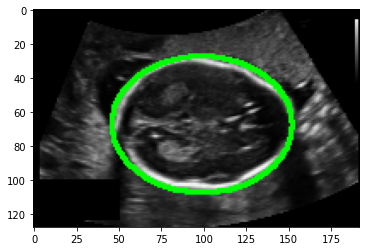

In [14]:
show_img_mask(np.squeeze(img),np.squeeze(mask))

In [15]:
from sklearn.model_selection import ShuffleSplit

In [16]:
sss = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)

indices = range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [17]:
from torch.utils.data import Subset

train_ds = Subset(fetal_ds1, train_index)
print(len(train_ds))

val_ds = Subset(fetal_ds2, val_index)
print(len(val_ds))



799
200


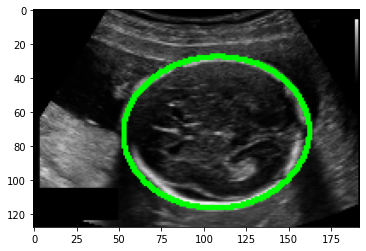

In [18]:
for img,mask in train_ds:
    show_img_mask(np.squeeze(img),np.squeeze(mask))
    break

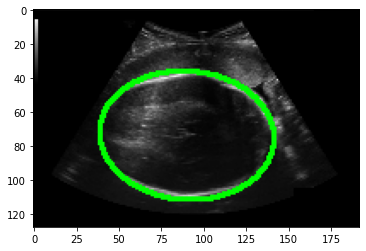

In [19]:
for img,mask in val_ds:
    show_img_mask(np.squeeze(img),np.squeeze(mask))
    break

In [20]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle = True)

val_dl = DataLoader(val_ds, batch_size=8, shuffle = False)

In [21]:
for x,y in train_dl:
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    break
for x,y in val_dl:
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


## Defining the model

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs = params["num_outputs"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size = 3, stride = 1, padding = 1)
        
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        
        self.conv_up1 = nn.Conv2d(16*init_f,8*init_f, kernel_size= 3, padding = 1)
        self.conv_up2 = nn.Conv2d(8*init_f,4*init_f, kernel_size= 3, padding = 1)
        self.conv_up3 = nn.Conv2d(4*init_f,2*init_f, kernel_size= 3, padding = 1)
        self.conv_up4 = nn.Conv2d(2*init_f,init_f, kernel_size= 3, padding = 1)
        
        self.conv_out = nn.Conv2d(init_f, num_outputs, kernel_size=3, padding = 1)
        
    def forward(self,x):
        #Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv5(x))
        
        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))
        
        x = self.conv_out(x)
        
        return x
        
        
        
        
        

In [24]:
params_model = {
    "input_shape": (1,h,w), 
    "initial_filters": 16,
    "num_outputs": 1,
}
model = SegNet(params_model)

In [25]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [26]:
import torch.nn.functional as F

def dice_loss(pred,target, smooth = 1e-5):
    intersection = (pred*target).sum(dim= (2,3))
    union = pred.sum(dim= (2,3)) + target.sum(dim= (2,3))
    dice = 2.0 * (intersection+smooth)/(union+smooth)
    loss = 1-dice
    return loss.sum(), dice.sum()

def loss_func(pred,target):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction = 'sum')
    pred = torch.sigmoid(pred)
    div,_ = dice_loss(pred,target)
    loss = bce + div
    return loss


def metric_batch(pred, target):
    pred = torch.sigmoid(pred)
    _,metric  = dice_loss(pred, target)
    return metric

In [27]:
def loss_batch(loss_func, output, target, opt = None):
    loss = loss_func(output,target)
    _, metric_b = dice_loss(torch.sigmoid(output), target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b

In [28]:
from torch import optim
from tqdm import tqdm
opt = optim.Adam(model.parameters(), lr = 3e-4)

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode = 'min', factor = 0.5, patience=20, verbose = 1)


In [30]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check = False, opt= None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb,yb in tqdm(dataset_dl):
        xb = xb.type(torch.float32).to(device)
#         print(device)
        yb  = yb.type(torch.float32).to(device)
        
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        running_metric += metric_b
        
    loss = running_loss/len_data
    metric = running_metric/len_data
    
    return loss, metric

In [31]:
def get_lr(opt):
    
    for param in opt.param_groups:
        return param['lr']

In [32]:
import copy

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    
    loss_history = {
        "train": [],
        "val": []
    }
    
    metric_history = {
        "train": [],
        "val": []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        
        print(f"Epochs: {epoch+1}/{num_epochs} Current Learning Rate: {current_lr}")
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt = opt)
        loss_history['train'].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check, opt = None)
            loss_history['val'].append(val_loss)
            metric_history["val"].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Best model saved")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("loading best wts")
            model.load_state_dict(best_model_wts)
            
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric)) 
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("-"*10)
        
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

            
    

In [33]:
torch.cuda.empty_cache()


In [34]:
params_train={
"num_epochs": 75,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": "./"+"weights.pt",
}

In [35]:
model,loss_hist,metric_hist=train_val(model,params_train)



  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 1/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

Best model saved
train loss: 13886.362651, dice: 36.19
val loss: 9887.349336, dice: 48.36
----------
Epochs: 2/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.07it/s]

Best model saved
train loss: 6995.963485, dice: 65.60
val loss: 5984.022578, dice: 75.85
----------
Epochs: 3/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.10it/s]

Best model saved
train loss: 5174.214059, dice: 75.12
val loss: 4955.471758, dice: 76.91
----------
Epochs: 4/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.09it/s]

Best model saved
train loss: 4532.066489, dice: 77.57
val loss: 4622.733721, dice: 81.40
----------
Epochs: 5/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 3676.977474, dice: 81.33
val loss: 3446.459116, dice: 83.90
----------
Epochs: 6/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.13it/s]

Best model saved
train loss: 3151.269594, dice: 83.76
val loss: 3038.241895, dice: 84.35
----------
Epochs: 7/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.04it/s]

Best model saved
train loss: 2819.384668, dice: 85.19
val loss: 2758.448311, dice: 86.94
----------
Epochs: 8/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.19it/s]

train loss: 2559.428237, dice: 86.91
val loss: 2981.107910, dice: 85.81
----------
Epochs: 9/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 2315.303358, dice: 88.04
val loss: 2376.928628, dice: 88.86
----------
Epochs: 10/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 2233.205859, dice: 88.85
val loss: 2338.605752, dice: 88.56
----------
Epochs: 11/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:18,  5.22it/s]

Best model saved
train loss: 2029.416189, dice: 89.89
val loss: 2121.998931, dice: 87.71
----------
Epochs: 12/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.06it/s]

Best model saved
train loss: 1792.984360, dice: 90.97
val loss: 1935.097212, dice: 88.77
----------
Epochs: 13/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:18,  5.22it/s]

Best model saved
train loss: 1769.911856, dice: 91.27
val loss: 1891.323408, dice: 90.58
----------
Epochs: 14/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.15it/s]

Best model saved
train loss: 1703.549118, dice: 91.42
val loss: 1881.544690, dice: 91.26
----------
Epochs: 15/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.04it/s]

Best model saved
train loss: 1581.281387, dice: 92.25
val loss: 1638.157654, dice: 91.93
----------
Epochs: 16/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:18,  5.24it/s]

train loss: 1526.571224, dice: 92.46
val loss: 1653.018640, dice: 91.99
----------
Epochs: 17/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1607.183321, dice: 92.29
val loss: 1643.328340, dice: 90.86
----------
Epochs: 18/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:18,  5.21it/s]

train loss: 1478.131169, dice: 92.70
val loss: 1645.252505, dice: 91.43
----------
Epochs: 19/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.10it/s]

Best model saved
train loss: 1429.174653, dice: 92.89
val loss: 1587.619956, dice: 91.83
----------
Epochs: 20/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.12it/s]

Best model saved
train loss: 1425.607726, dice: 93.00
val loss: 1510.327522, dice: 93.03
----------
Epochs: 21/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 1329.839480, dice: 93.32
val loss: 1432.692312, dice: 93.04
----------
Epochs: 22/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.08it/s]

train loss: 1316.959193, dice: 93.49
val loss: 1462.777458, dice: 92.73
----------
Epochs: 23/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1332.815594, dice: 93.57
val loss: 1542.848049, dice: 92.37
----------
Epochs: 24/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 1327.866953, dice: 93.52
val loss: 1410.222429, dice: 93.20
----------
Epochs: 25/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

train loss: 1236.881423, dice: 94.04
val loss: 1818.139172, dice: 90.96
----------
Epochs: 26/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.01it/s]

train loss: 1241.854016, dice: 93.75
val loss: 1448.667356, dice: 93.46
----------
Epochs: 27/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.18it/s]

Best model saved
train loss: 1234.994802, dice: 93.84
val loss: 1337.360303, dice: 93.79
----------
Epochs: 28/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

train loss: 1295.490278, dice: 93.89
val loss: 1541.887485, dice: 93.16
----------
Epochs: 29/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.15it/s]

train loss: 1193.086320, dice: 94.14
val loss: 1970.093398, dice: 90.77
----------
Epochs: 30/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.06it/s]

train loss: 1161.449123, dice: 94.14
val loss: 1421.349272, dice: 92.87
----------
Epochs: 31/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.21it/s]

train loss: 1148.570712, dice: 94.48
val loss: 1420.759297, dice: 92.08
----------
Epochs: 32/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 1136.308714, dice: 94.39
val loss: 1321.301582, dice: 93.57
----------
Epochs: 33/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.11it/s]

train loss: 1099.712309, dice: 94.57
val loss: 1560.720278, dice: 93.11
----------
Epochs: 34/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.13it/s]

train loss: 1125.913501, dice: 94.22
val loss: 1361.483186, dice: 94.03
----------
Epochs: 35/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.01it/s]

train loss: 1086.774831, dice: 94.66
val loss: 1321.547021, dice: 93.84
----------
Epochs: 36/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.10it/s]

Best model saved
train loss: 1059.686868, dice: 94.59
val loss: 1279.661680, dice: 93.95
----------
Epochs: 37/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1019.269142, dice: 94.95
val loss: 1453.989260, dice: 93.95
----------
Epochs: 38/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1005.207892, dice: 94.84
val loss: 1330.866204, dice: 94.01
----------
Epochs: 39/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.18it/s]

train loss: 942.483040, dice: 95.14
val loss: 1313.795208, dice: 94.17
----------
Epochs: 40/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Best model saved
train loss: 978.912585, dice: 95.00
val loss: 1250.949192, dice: 94.08
----------
Epochs: 41/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.12it/s]

train loss: 1003.742789, dice: 95.17
val loss: 1329.132822, dice: 93.71
----------
Epochs: 42/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.07it/s]

train loss: 988.163851, dice: 94.95
val loss: 1324.446008, dice: 93.94
----------
Epochs: 43/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 914.574662, dice: 95.27
val loss: 1430.374316, dice: 93.76
----------
Epochs: 44/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1044.439649, dice: 94.79
val loss: 1615.304729, dice: 92.70
----------
Epochs: 45/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.11it/s]

train loss: 1008.517926, dice: 94.74
val loss: 1367.954197, dice: 94.29
----------
Epochs: 46/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.09it/s]

train loss: 888.783961, dice: 95.43
val loss: 1319.844453, dice: 93.78
----------
Epochs: 47/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:18,  5.23it/s]

train loss: 847.503230, dice: 95.52
val loss: 1316.163652, dice: 94.66
----------
Epochs: 48/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 843.952484, dice: 95.58
val loss: 1348.240610, dice: 94.29
----------
Epochs: 49/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.15it/s]

train loss: 833.509491, dice: 95.65
val loss: 1356.881196, dice: 94.13
----------
Epochs: 50/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.16it/s]

train loss: 811.372148, dice: 95.65
val loss: 1301.921453, dice: 94.58
----------
Epochs: 51/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 810.991003, dice: 95.71
val loss: 1328.912976, dice: 94.52
----------
Epochs: 52/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.19it/s]

train loss: 791.070724, dice: 95.82
val loss: 1272.072371, dice: 94.69
----------
Epochs: 53/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.07it/s]

train loss: 860.464505, dice: 95.58
val loss: 1343.832402, dice: 94.14
----------
Epochs: 54/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 880.344966, dice: 95.43
val loss: 1440.254756, dice: 94.24
----------
Epochs: 55/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.12it/s]

train loss: 767.995231, dice: 95.92
val loss: 1351.829473, dice: 94.51
----------
Epochs: 56/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 761.998497, dice: 95.94
val loss: 1252.224646, dice: 94.71
----------
Epochs: 57/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.18it/s]

train loss: 745.248459, dice: 95.99
val loss: 1301.730134, dice: 94.73
----------
Epochs: 58/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:18,  5.22it/s]

train loss: 731.460947, dice: 96.09
val loss: 1325.833467, dice: 94.66
----------
Epochs: 59/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 779.538466, dice: 95.90
val loss: 1382.254646, dice: 94.55
----------
Epochs: 60/75 Current Learning Rate: 0.0003


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

train loss: 751.485586, dice: 95.99
val loss: 1311.565959, dice: 94.57
----------
Epochs: 61/75 Current Learning Rate: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch    61: reducing learning rate of group 0 to 1.5000e-04.
loading best wts
train loss: 714.029597, dice: 96.16
val loss: 1316.019531, dice: 94.73
----------
Epochs: 62/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 868.054728, dice: 95.38
val loss: 1253.939939, dice: 94.29
----------
Epochs: 63/75 Current Learning Rate: 0.00015


  1%|          | 1/100 [00:00<00:19,  5.06it/s]

train loss: 936.221034, dice: 95.25
val loss: 1325.119412, dice: 94.15
----------
Epochs: 64/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 863.308020, dice: 95.51
val loss: 1265.686768, dice: 94.38
----------
Epochs: 65/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 829.476181, dice: 95.62
val loss: 1288.756951, dice: 94.38
----------
Epochs: 66/75 Current Learning Rate: 0.00015


  1%|          | 1/100 [00:00<00:19,  5.11it/s]

Best model saved
train loss: 819.967867, dice: 95.69
val loss: 1245.823772, dice: 94.60
----------
Epochs: 67/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 850.178459, dice: 95.66
val loss: 1420.785986, dice: 93.78
----------
Epochs: 68/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 830.180944, dice: 95.62
val loss: 1290.261897, dice: 94.55
----------
Epochs: 69/75 Current Learning Rate: 0.00015


  1%|          | 1/100 [00:00<00:19,  5.19it/s]

train loss: 794.667489, dice: 95.80
val loss: 1248.908577, dice: 94.68
----------
Epochs: 70/75 Current Learning Rate: 0.00015


  1%|          | 1/100 [00:00<00:18,  5.26it/s]

train loss: 925.142083, dice: 95.39
val loss: 1268.627146, dice: 94.51
----------
Epochs: 71/75 Current Learning Rate: 0.00015


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

train loss: 782.576704, dice: 95.86
val loss: 1293.388667, dice: 94.58
----------
Epochs: 72/75 Current Learning Rate: 0.00015


  1%|          | 1/100 [00:00<00:19,  5.12it/s]

train loss: 773.804035, dice: 95.93
val loss: 1290.540774, dice: 94.76
----------
Epochs: 73/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 746.871595, dice: 96.02
val loss: 1319.994331, dice: 94.82
----------
Epochs: 74/75 Current Learning Rate: 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 770.602179, dice: 95.92
val loss: 1256.867876, dice: 94.82
----------
Epochs: 75/75 Current Learning Rate: 0.00015


100%|██████████| 25/25 [00:04<00:00,  5.23it/s]

train loss: 737.747002, dice: 96.06
val loss: 1321.498752, dice: 94.70
----------


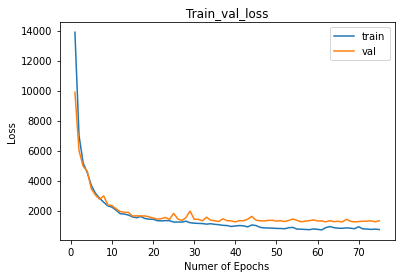

In [36]:
num_epochs = params_train['num_epochs']

plt.figure()
plt.plot(range(1, num_epochs+1), loss_hist['train'], label = 'train')

plt.plot(range(1, num_epochs+1), loss_hist['val'], label = 'val')
plt.xlabel("Numer of Epochs")
plt.ylabel("Loss")
plt.title("Train_val_loss")
plt.legend()


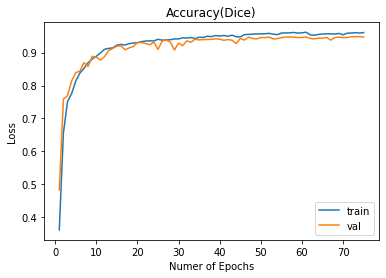

In [37]:
num_epochs = params_train['num_epochs']

plt.figure()
plt.plot(range(1, num_epochs+1), metric_hist['train'], label = 'train')

plt.plot(range(1, num_epochs+1), metric_hist['val'], label = 'val')
plt.xlabel("Numer of Epochs")
plt.ylabel("Loss")
plt.title("Accuracy(Dice)")
plt.legend()


### Deploying the Model

In [38]:
path2testdata = '../input/fetal-detection-and-test/test_set/test_set'

img_list = os.listdir(path2testdata)

In [42]:
rnd_imgs = np.random.choice(img_list, 4)

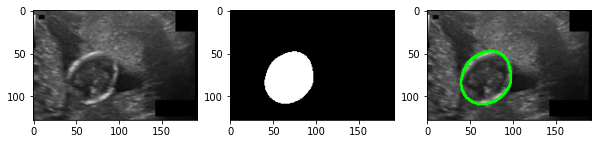

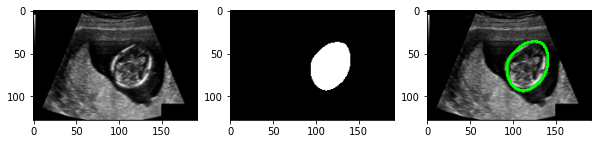

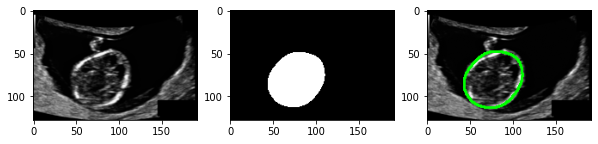

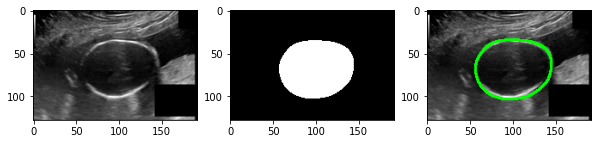

In [72]:
for i in rnd_imgs:
    model.eval()
    with torch.no_grad():
        img = Image.open(os.path.join(path2testdata, i))
        img = img.resize((w,h))
        img_t = to_tensor(img).unsqueeze(0).to(device)
        pred = model(img_t)
        pred=torch.sigmoid(pred)[0]
        mask_pred= (pred[0]>=0.5)
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred.cpu().detach().numpy(), cmap="gray")
    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred.cpu().detach().numpy())
    